# PyTorch Saving and Loading Models

Following along with this tutorial:
- https://github.com/udacity/DL_PyTorch
- https://pytorch.org/tutorials/beginner/saving_loading_models.html

When it comes to saving and loading models, there are three core functions to be familiar with:

1. `torch.save`: Saves a serialized object to disk. This function uses Python’s pickle utility for serialization. Models, tensors, and dictionaries of all kinds of objects can be saved using this function.
1. `torch.load`: Uses pickle’s unpickling facilities to deserialize pickled object files to memory. This function also facilitates the device to load the data into (see Saving & Loading Model Across Devices).
1. `torch.nn.Module.load_state_dict`: Loads a model’s parameter dictionary into the network using a deserialized state_dict.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper
import fc_model

## What is a ``state_dict``?

In PyTorch, the learnable parameters (i.e. weights and biases) of an
``torch.nn.Module`` model is contained in the model’s *parameters*
(accessed with ``model.parameters()``). A *state_dict* is simply a
Python dictionary object that maps each layer to its parameter tensor.
Note that only layers with learnable parameters (convolutional layers,
linear layers, etc.) have entries in the model’s *state_dict*. Optimizer
objects (``torch.optim``) also have a *state_dict*, which contains
information about the optimizer’s state, as well as the hyperparameters
used.

Because *state_dict* objects are Python dictionaries, they can be easily
saved, updated, altered, and restored, adding a great deal of modularity
to PyTorch models and optimizers.

In [15]:
# Define model
class TheModelClass(nn.Module):
    def __init__(self):
        super(TheModelClass, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
model = TheModelClass()

# Initialize optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("\nOptimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [4382746376, 4717106304, 4717107096, 4717105584, 4717106232, 4717109184, 4716850632, 4716848904, 4716850416, 4716850344]}]


## 1. Saving and Loading a Model for Inference

### a) Save/Load ``state_dict`` (Recommended)

**Save:**

```
torch.save(model.state_dict(), PATH)
```

**Load:**

```
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
```

When saving a model for inference, it is only necessary to save the
trained model’s learned parameters. Saving the model’s *state_dict* with
the ``torch.save()`` function will give you the most flexibility for
restoring the model later, which is why it is the recommended method for
saving models.

A common PyTorch convention is to save models using either a ``.pt`` or
``.pth`` file extension.

Remember that you must call ``model.eval()`` to set dropout and batch
normalization layers to evaluation mode before running inference.
Failing to do this will yield inconsistent inference results.

### b) Save/Load Entire Model (Sounds very bad in practice)

**Save:**

```
torch.save(model, PATH)
```

**Load:**

```
# Model class must be defined somewhere
model = torch.load(PATH)
model.eval()
```

This save/load process uses the most intuitive syntax and involves the
least amount of code. Saving a model in this way will save the entire
module using Python’s
`pickle <https://docs.python.org/3/library/pickle.html>`__ module. The
disadvantage of this approach is that the serialized data is bound to
the specific classes and the exact directory structure used when the
model is saved. The reason for this is because pickle does not save the
model class itself. Rather, it saves a path to the file containing the
class, which is used during load time. Because of this, your code can
break in various ways when used in other projects or after refactors.

A common PyTorch convention is to save models using either a ``.pt`` or
``.pth`` file extension.

Remember that you must call ``model.eval()`` to set dropout and batch
normalization layers to evaluation mode before running inference.
Failing to do this will yield inconsistent inference results.

## 2. Saving and Loading a General Checkpoint for Inference and/or Resuming Training

**Save:**

```
torch.save({
           'epoch': epoch,
           'model_state_dict': model.state_dict(),
           'optimizer_state_dict': optimizer.state_dict(),
           'loss': loss,
           ...
           }, PATH)
```

**Load:**

```
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# - or -
model.train()
```

When saving a general checkpoint, to be used for either inference or
resuming training, you must save more than just the model’s
*state_dict*. It is important to also save the optimizer’s *state_dict*,
as this contains buffers and parameters that are updated as the model
trains. Other items that you may want to save are the epoch you left off
on, the latest recorded training loss, external ``torch.nn.Embedding``
layers, etc.

To save multiple components, organize them in a dictionary and use
``torch.save()`` to serialize the dictionary. A common PyTorch
convention is to save these checkpoints using the ``.tar`` file
extension.

To load the items, first initialize the model and optimizer, then load
the dictionary locally using ``torch.load()``. From here, you can easily
access the saved items by simply querying the dictionary as you would
expect.

Remember that you must call ``model.eval()`` to set dropout and batch
normalization layers to evaluation mode before running inference.
Failing to do this will yield inconsistent inference results. If you
wish to resuming training, call ``model.train()`` to ensure these layers
are in training mode.

## 3. Saving Multiple Models in One File

**Save:**

```
torch.save({
           'modelA_state_dict': modelA.state_dict(),
           'modelB_state_dict': modelB.state_dict(),
           'optimizerA_state_dict': optimizerA.state_dict(),
           'optimizerB_state_dict': optimizerB.state_dict(),
           ...
           }, PATH)
```

**Load:**

```
modelA = TheModelAClass(*args, **kwargs)
modelB = TheModelBClass(*args, **kwargs)
optimizerA = TheOptimizerAClass(*args, **kwargs)
optimizerB = TheOptimizerBClass(*args, **kwargs)

checkpoint = torch.load(PATH)
modelA.load_state_dict(checkpoint['modelA_state_dict'])
modelB.load_state_dict(checkpoint['modelB_state_dict'])
optimizerA.load_state_dict(checkpoint['optimizerA_state_dict'])
optimizerB.load_state_dict(checkpoint['optimizerB_state_dict'])

modelA.eval()
modelB.eval()
# - or -
modelA.train()
modelB.train()
```

When saving a model comprised of multiple ``torch.nn.Modules``, such as
a GAN, a sequence-to-sequence model, or an ensemble of models, you
follow the same approach as when you are saving a general checkpoint. In
other words, save a dictionary of each model’s *state_dict* and
corresponding optimizer. As mentioned before, you can save any other
items that may aid you in resuming training by simply appending them to
the dictionary.

A common PyTorch convention is to save these checkpoints using the
``.tar`` file extension.

To load the models, first initialize the models and optimizers, then
load the dictionary locally using ``torch.load()``. From here, you can
easily access the saved items by simply querying the dictionary as you
would expect.

Remember that you must call ``model.eval()`` to set dropout and batch
normalization layers to evaluation mode before running inference.
Failing to do this will yield inconsistent inference results. If you
wish to resuming training, call ``model.train()`` to set these layers to
training mode.

## 4. Warmstarting a Model Using Parameters from a Different Model

**Save:**

```
torch.save(modelA.state_dict(), PATH)
```

**Load:**

```
modelB = TheModelBClass(*args, **kwargs)
modelB.load_state_dict(torch.load(PATH), strict=False)
```

Partially loading a model or loading a partial model are common
scenarios when transfer learning or training a new complex model.
Leveraging trained parameters, even if only a few are usable, will help
to warmstart the training process and hopefully help your model converge
much faster than training from scratch.

Whether you are loading from a partial *state_dict*, which is missing
some keys, or loading a *state_dict* with more keys than the model that
you are loading into, you can set the ``strict`` argument to **False**
in the ``load_state_dict()`` function to ignore non-matching keys.

If you want to load parameters from one layer to another, but some keys
do not match, simply change the name of the parameter keys in the
*state_dict* that you are loading to match the keys in the model that
you are loading into.

## 5. Saving and Loading a Model Across Devices

### a) Save on GPU, Load on CPU

**Save:**

```
torch.save(model.state_dict(), PATH)
```

**Load:**

```
device = torch.device('cpu')
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH, map_location=device))
```

When loading a model on a CPU that was trained with a GPU, pass
``torch.device('cpu')`` to the ``map_location`` argument in the
``torch.load()`` function. In this case, the storages underlying the
tensors are dynamically remapped to the CPU device using the
``map_location`` argument.

### b) Save on GPU, Load on GPU

**Save:**

```
torch.save(model.state_dict(), PATH)
```

**Load:**

```
device = torch.device("cuda")
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.to(device)
# Make sure to call input = input.to(device) on any input tensors that you feed to the model
```

When loading a model on a GPU that was trained and saved on GPU, simply
convert the initialized ``model`` to a CUDA optimized model using
``model.to(torch.device('cuda'))``. Also, be sure to use the
``.to(torch.device('cuda'))`` function on all model inputs to prepare
the data for the model. Note that calling ``my_tensor.to(device)``
returns a new copy of ``my_tensor`` on GPU. It does NOT overwrite
``my_tensor``. Therefore, remember to manually overwrite tensors:
``my_tensor = my_tensor.to(torch.device('cuda'))``.

### c) Save on CPU, Load on GPU

**Save:**

```
torch.save(model.state_dict(), PATH)
```

**Load:**

```
device = torch.device("cuda")
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH, map_location="cuda:0"))  # Choose whatever GPU device number you want
model.to(device)
# Make sure to call input = input.to(device) on any input tensors that you feed to the model
```

When loading a model on a GPU that was trained and saved on CPU, set the
``map_location`` argument in the ``torch.load()`` function to
*cuda:device_id*. This loads the model to a given GPU device. Next, be
sure to call ``model.to(torch.device('cuda'))`` to convert the model’s
parameter tensors to CUDA tensors. Finally, be sure to use the
``.to(torch.device('cuda'))`` function on all model inputs to prepare
the data for the CUDA optimized model. Note that calling
``my_tensor.to(device)`` returns a new copy of ``my_tensor`` on GPU. It
does NOT overwrite ``my_tensor``. Therefore, remember to manually
overwrite tensors: ``my_tensor = my_tensor.to(torch.device('cuda'))``.

### d) Saving ``torch.nn.DataParallel`` Models

**Save:**

```
torch.save(model.module.state_dict(), PATH)
```

**Load:**

```
# Load to whatever device you want
```

``torch.nn.DataParallel`` is a model wrapper that enables parallel GPU
utilization. To save a ``DataParallel`` model generically, save the
``model.module.state_dict()``. This way, you have the flexibility to
load the model any way you want to any device you want.

## Saving and Loading Example Using Methods 1a and 2

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

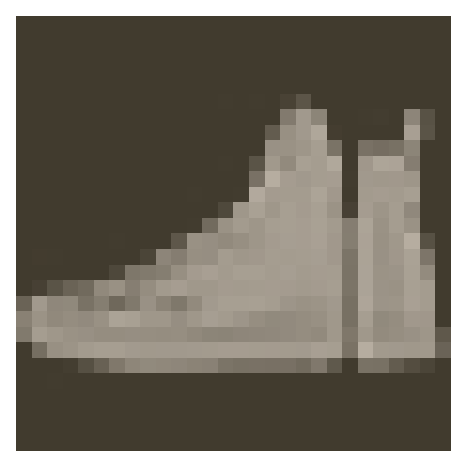

In [3]:
# Show an image
image, label = next(iter(trainloader))
helper.imshow(image[0,:])

Model architecture and training code is in a file called `fc_model`. Importing this, we can easily create a fully-connected network with `fc_model.Network`, and train the network using `fc_model.train`. I'll use this model (once it's trained) to demonstrate how we can save and load models.

In [4]:
# Create the network, define the criterion and optimizer
model = fc_model.Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 1.671..  Test Loss: 0.955..  Test Accuracy: 0.660
Epoch: 1/2..  Training Loss: 0.985..  Test Loss: 0.743..  Test Accuracy: 0.725
Epoch: 1/2..  Training Loss: 0.872..  Test Loss: 0.694..  Test Accuracy: 0.745
Epoch: 1/2..  Training Loss: 0.801..  Test Loss: 0.633..  Test Accuracy: 0.759
Epoch: 1/2..  Training Loss: 0.750..  Test Loss: 0.632..  Test Accuracy: 0.759
Epoch: 1/2..  Training Loss: 0.727..  Test Loss: 0.596..  Test Accuracy: 0.773
Epoch: 1/2..  Training Loss: 0.688..  Test Loss: 0.608..  Test Accuracy: 0.761
Epoch: 1/2..  Training Loss: 0.676..  Test Loss: 0.573..  Test Accuracy: 0.783
Epoch: 1/2..  Training Loss: 0.647..  Test Loss: 0.547..  Test Accuracy: 0.800
Epoch: 1/2..  Training Loss: 0.667..  Test Loss: 0.551..  Test Accuracy: 0.798
Epoch: 1/2..  Training Loss: 0.650..  Test Loss: 0.544..  Test Accuracy: 0.799
Epoch: 1/2..  Training Loss: 0.653..  Test Loss: 0.520..  Test Accuracy: 0.807
Epoch: 1/2..  Training Loss: 0.629..  Test Loss: 0.5

### Saving and loading a network with the same architecture

The parameters for PyTorch networks are stored in a model's `state_dict`. We can see the state dict contains the weight and bias matrices for each of our layers.

In [6]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


The simplest thing to do is simply save the state dict with `torch.save`. For example, we can save it to a file `'checkpoint.pth'`.

In [7]:
# 1
torch.save(model.state_dict(), 'checkpoint.pth')

In [ ]:
d

In [8]:
# 2
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


In [9]:
# 3
model.load_state_dict(state_dict)

### Saving and loading a network with different architecture

Seems pretty straightforward, but as usual it's a bit more complicated. Loading the state dict works only if the model architecture is exactly the same as the checkpoint architecture. If I create a model with a different architecture, this fails.

In [10]:
# Try this
model = fc_model.Network(784, 10, [400, 200, 100])
# This will throw an error because the tensor sizes are wrong!
model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for Network:
	While copying the parameter named "hidden_layers.0.weight", whose dimensions in the model are torch.Size([400, 784]) and whose dimensions in the checkpoint are torch.Size([512, 784]).
	While copying the parameter named "hidden_layers.0.bias", whose dimensions in the model are torch.Size([400]) and whose dimensions in the checkpoint are torch.Size([512]).
	While copying the parameter named "hidden_layers.1.weight", whose dimensions in the model are torch.Size([200, 400]) and whose dimensions in the checkpoint are torch.Size([256, 512]).
	While copying the parameter named "hidden_layers.1.bias", whose dimensions in the model are torch.Size([200]) and whose dimensions in the checkpoint are torch.Size([256]).
	While copying the parameter named "hidden_layers.2.weight", whose dimensions in the model are torch.Size([100, 200]) and whose dimensions in the checkpoint are torch.Size([128, 256]).
	While copying the parameter named "hidden_layers.2.bias", whose dimensions in the model are torch.Size([100]) and whose dimensions in the checkpoint are torch.Size([128]).
	While copying the parameter named "output.weight", whose dimensions in the model are torch.Size([10, 100]) and whose dimensions in the checkpoint are torch.Size([10, 128]).

This means we need to rebuild the model exactly as it was when trained. Information about the model architecture needs to be saved in the checkpoint, along with the state dict. To do this, you build a dictionary with all the information you need to compeletely rebuild the model.

In [11]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

Now the checkpoint has all the necessary information to rebuild the trained model. You can easily make that a function if you want. Similarly, we can write a function to load checkpoints.

In [12]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [13]:
model = load_checkpoint('checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=100, bias=True)
  )
  (output): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
)
